In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# !pip install fast-histogram colorcet
# !pip install optbinning
# !pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 1.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 5.2 MB/s 
     |████████████████████████████████| 15.5 MB 391 kB/s 
     |████████████████████████████████| 408 kB 37.3 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.21.4 which is incompatible.
tensorflow-metadata 1.9.0 requires protobuf<4,>=3.13, but you have protobuf 4.21.4 which is incompatible.
googl

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorcet as cc
import matplotlib.colors as colors
# from fast_histogram import histogram2d
import seaborn as sns
from sklearn import linear_model

from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import copy
# from optbinning import ContinuousOptimalBinning

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.cluster import KMeans
import warnings
import pickle

warnings.filterwarnings('ignore')


from statsmodels.api import OLS

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load Data

In [5]:
def load_data():
    return pd.read_csv('drive/Shareddrives/DS4W-Team/Data/train.csv', header = 0, index_col = "id")
train = load_data()


In [ ]:
test = pd.read_csv('drive/Shareddrives/DS4W-Team/Data/test.csv', header = 0, index_col = "id")

In [ ]:
pd.options.display.max_columns = 140
#pd.set_option('display.max_rows', None)

## Codes

### Data cleaning process

In [7]:
def impute(data):
    missing_fog_wind_features = ['days_with_fog', 'direction_peak_wind_speed', 'max_wind_speed', 'direction_max_wind_speed']
    data_copy = copy.deepcopy(data)
    data_copy[missing_fog_wind_features] = data_copy.groupby(['Year_Factor', 'State_Factor', 'avg_temp'])[missing_fog_wind_features].transform('mean')
    data_copy[missing_fog_wind_features] = data_copy.groupby(['Year_Factor', 'State_Factor'])[missing_fog_wind_features].transform(lambda x: x.fillna(x.mean()))
    data_copy[missing_fog_wind_features] = data_copy.groupby('Year_Factor')[missing_fog_wind_features].transform(lambda x: x.fillna(x.mean()))

    data_copy['energy_star_rating'].fillna(data_copy['energy_star_rating'].mean(), inplace = True)
    
    
    data_copy['year_built'] = np.where((data_copy.year_built==0) | (np.isnan(data_copy.year_built)), data_copy.year_built.median(), data_copy.year_built)
    data_copy['age'] = 2022 - data_copy['year_built']
    data_copy.drop('year_built', axis = 1, inplace = True)
    return data_copy


In [8]:
def impute_test(data):
    missing_fog_wind_features = ['days_with_fog', 'direction_peak_wind_speed', 'max_wind_speed', 'direction_max_wind_speed']
    data_copy = copy.deepcopy(data)
    data_copy[missing_fog_wind_features] = data_copy.groupby(['State_Factor', 'avg_temp'])[missing_fog_wind_features].transform('mean')
    data_copy[missing_fog_wind_features] = data_copy.groupby(['State_Factor'])[missing_fog_wind_features].transform(lambda x: x.fillna(x.mean()))
    data_copy['energy_star_rating'].fillna(data_copy['energy_star_rating'].mean(), inplace = True)
    data_copy['year_built'] = np.where((data_copy.year_built==0) | (np.isnan(data_copy.year_built)), data_copy.year_built.median(), data_copy.year_built)
    data_copy['age'] = 2022 - data_copy['year_built']
    data_copy.drop('year_built', axis = 1, inplace = True)
    return data_copy

In [9]:
def feature_engineering(data):
    
    data_copy = copy.deepcopy(data)
    
    # transform floor_area
    data_copy['floor_area'] = np.log10(data_copy['floor_area'])
    
    # add temperature span in a year
    data_copy['temp_year_span'] = max(data_copy.iloc[:, 8:44].max()) - min(data_copy.iloc[:, 8:44].min())
    
    # Delete highly correlated variables
    to_be_deleted_variables = ['days_below_10F', 'direction_max_wind_speed', 'max_wind_speed']
    data_copy.drop(to_be_deleted_variables, axis = 1, inplace = True)
    
    return data_copy

In [10]:
def season_effects(data):

    months = ['january', 'february', 'march', 'april', 'may', 'june', 'july',
          'august', 'september', 'october', 'november', 'december']
            
    data_copy = copy.deepcopy(data)
    # Seasonal effects
    data_copy['1_min']=data_copy[['january_min_temp','february_min_temp']].min(axis=1)
    data_copy['2_min']=data_copy[['march_min_temp', 'november_min_temp','december_min_temp']].min(axis=1)
    data_copy['3_min']=data_copy[['april_min_temp', 'may_min_temp', 'october_min_temp']].min(axis=1)
    data_copy['4_min']=data_copy[['june_min_temp','july_min_temp','august_min_temp','september_min_temp']].min(axis=1)

    data_copy['1_avg']=data_copy[['january_avg_temp','february_avg_temp']].min(axis=1)
    data_copy['2_avg']=data_copy[['march_avg_temp', 'november_avg_temp','december_avg_temp']].min(axis=1)
    data_copy['3_avg']=data_copy[['april_avg_temp', 'may_avg_temp', 'october_avg_temp']].min(axis=1)
    data_copy['4_avg']=data_copy[['june_avg_temp','july_avg_temp','august_avg_temp','september_avg_temp']].min(axis=1)

    data_copy['1_max']=data_copy[['january_max_temp','february_max_temp']].min(axis=1)
    data_copy['2_max']=data_copy[['march_max_temp', 'november_max_temp','december_max_temp']].min(axis=1)
    data_copy['3_max']=data_copy[['april_max_temp', 'may_max_temp', 'october_max_temp']].min(axis=1)
    data_copy['4_max']=data_copy[['june_max_temp','july_max_temp','august_max_temp','september_max_temp']].min(axis=1)

    # drop months
    for i in months:
        data_copy.drop([f'{i}_min_temp'],axis=1,inplace=True)
        data_copy.drop([f'{i}_avg_temp'],axis=1,inplace=True)
        data_copy.drop([f'{i}_max_temp'],axis=1,inplace=True)
    return data_copy

In [11]:
# internel function
def clean_without_dummies(data):
    
    # Impute missing values
    data = impute(data)
    
    data = feature_engineering(data)
    
    data = season_effects(data)
    
    return data

In [12]:
def to_dummies(data, enc=None):
    data_copy = copy.deepcopy(data)
    data_copy_index = data_copy.index

    data_copy['Year_Factor'] = data_copy['Year_Factor'].astype('object')

    Categorical_features = data_copy.select_dtypes(include='object').columns.to_list()
    x_cat = data_copy[Categorical_features]

    if enc is None:
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(x_cat)
    x_cat_arr = enc.transform(x_cat).toarray()

    
    x_cat_df = pd.DataFrame(x_cat_arr, columns = enc.get_feature_names(Categorical_features), index = data_copy_index)

    data_copy = pd.concat([data_copy, x_cat_df], axis = 1).drop(Categorical_features, axis = 1)

    return data_copy, enc

In [13]:
def clean_without_grouping_facility_types(data):
    
    # Impute missing values
    data = impute(data)

    data = feature_engineering(data)

    data = season_effects(data)
    
    data, enc = to_dummies(data)
    return data

In [14]:
def group_facility_types(data):
    
    data_used_inside_func = copy.deepcopy(data)
    # get preprocessed data with facility dummies but without grouping facility types.
    data_used_inside_func = clean_without_grouping_facility_types(data_used_inside_func)
    
    facility_index = []
    column_names = data_used_inside_func.columns.tolist()
    
    for i, s in enumerate(column_names):
        if "facility_type" in s:
            facility_index.append(i)
    
    facility_names = column_names[facility_index[0]:(facility_index[-1]+1)]
    
    facilities = data_used_inside_func.iloc[:, facility_index[0]:(facility_index[-1]+1)]
    
    facilities_transpose = facilities.transpose()

    Kmean = KMeans(n_clusters=25)
    Kmean.fit(facilities_transpose)
    facility_groups = Kmean.labels_
    
    dict_facilities = {}
    for i in range(60):
        dict_facilities.update({facility_names[i][14:]: f'facility_group_{facility_groups[i]}'})
        
    # Get prepoccessed dataset but before changing facility variables to dummies.
    data_without_dummies = clean_without_dummies(data)
    # Group facilities.
    data_without_dummies['facility_type'] = data_without_dummies['facility_type'].replace(dict_facilities)
    
    
    return data_without_dummies, dict_facilities

final_clean(data): inpute a raw dataset, output a clean dataset ready for model selection.

In [15]:
def final_clean(data):
    
    data_without_dummies, dict_facilities = group_facility_types(data)
    
    data, enc = to_dummies(data_without_dummies)
    return data, dict_facilites, enc

In [16]:
def transform_test_data(data, dict_facilities, predictors, enc):
    # Get prepoccessed dataset but before changing facility variables to dummies.
    
    data = impute_test(data)
    
    data = feature_engineering(data)
    
    data_without_dummies = season_effects(data)
    
    # Group facilities.
    data_without_dummies['facility_type'] = data_without_dummies['facility_type'].replace(dict_facilities)
    #print('data_without_dummies is: \n')
    #display(data_without_dummies)
    
    data, _ = to_dummies(data_without_dummies, enc)

    data = data.loc[:, predictors]
    #print(f'final data: {data}')
    
    return data

### Model selection functions

In [4]:
def ols(data):
    x = data.loc[:, data.columns != 'site_eui']
    y = data['site_eui']
    model = sm.OLS(y, x)
    return model.fit().summary()

In [22]:
def validateMSE(data, test_size, random_state):
    dfX = data.loc[:, data.columns != 'site_eui']
    dfy = data['site_eui']
    X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=test_size, random_state=random_state)
    # fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    # evaluate the model
    yhat_test = model.predict(X_test)
    # evaluate predictions
    mae_test = mean_absolute_error(y_test, yhat_test)
    rmse_test = mean_squared_error(y_test, yhat_test, squared = False)
    r2_test = r2_score(y_test, yhat_test)
    print("mae_test is: ", mae_test)
    print("rmse_test is: ", rmse_test)
    print("R^2_test is: ", r2_test)

    
    # evaluate the model
    yhat_train = model.predict(X_train)
    
    # evaluate estimation
    mae_train = mean_absolute_error(y_train, yhat_train)
    rmse_train = mean_squared_error(y_train, yhat_train, squared = False)
    r2_train = r2_score(y_train, yhat_train)
    print("mae_train is: ", mae_train)
    print("rmse_train is: ", rmse_train)
    print("R^2_train is: ", r2_train)
   

    # Plot outputs
    
    # 100 linearly spaced numbers
    x = np.linspace(0,500,100)

    # the function, which is y = x^2 here
    y = x
    
    plt.scatter(y_test, yhat_test, color="red", alpha=0.5, s = 0.5)
    plt.plot(x, y, color="blue", linewidth=3)

    plt.xlim([0, 250])
    plt.ylim([0, 250])
    # plt.xticks(())
    # plt.yticks(())
    
    plt.xlabel("Ground truth for validation data")
    plt.ylabel("Prediction for validation data")

    plt.show()

In [6]:
def stepwise_selection(data, target, SL_in=0.05, SL_out = 0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break 
        else:
            break
    return best_features

In [ ]:
def backward_elimination(data, target,significance_level = 0.05):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
    return features

In [ ]:
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

In [ ]:
# Sequential Forward Floating Selection(sffs) (stepwise)
def stepwise_sfs(X, y, number_of_features):
    sffs = SFS(LinearRegression(),
             k_features= number_of_features,
             forward=True,
             floating=True,
             cv=0)
    sffs.fit(X, y)
    return sffs.k_feature_names_

### Model selection and output train data

In [20]:
# train = load_data()

# train, dict_facility, train_enc = final_clean(train)

# pickle.dump(dict_facility, open("drive/Shareddrives/DS4W-Team/Data/dict_facility.pickle", "wb"))
# pickle.dump(train_enc, open("drive/Shareddrives/DS4W-Team/Data/train_enc.pickle", "wb"))

################### This is the resulting dataset and facility grouping.
dict_facilities = pickle.load(open("drive/Shareddrives/DS4W-Team/Data/dict_facility.pickle", "rb"))
train_enc = pickle.load(open("drive/Shareddrives/DS4W-Team/Data/train_enc.pickle", "rb"))

train_38_sfs = pd.read_csv('drive/Shareddrives/DS4W-Team/Data/train_38_predictors.csv', header = 0)

In [ ]:
# X = train.loc[:, train.columns != 'site_eui']
# y = train['site_eui']

#stepwise_p_features = stepwise_selection(X, y, SL_in=0.05, SL_out = 0.05)

When I ran stepwise regression with p-value for the first time, the number of important features selected was 38. So I use 38 as input to the built-in sequential feature selector in sklearn to select the best 38 features.

In [ ]:
#train_38_predictors_sfs = stepwise_sfs(X, y, 38)

In [ ]:
#pickle.dump(train_38_predictors_sfs, open("train_38_predictors_sfs_list.pickle", "wb"))

In [ ]:
train_38_predictors_sfs = pickle.load(open("drive/Shareddrives/DS4W-Team/Data/train_38_predictors_sfs_list.pickle", "rb"))

In [ ]:
# train_38_predictors_sfs = list(train_38_predictors_sfs)
# X_y_sfs = copy.deepcopy(train_38_predictors_sfs)
# X_y_sfs.append('site_eui')
# train_38_sfs = train.loc[:, X_y_sfs]

In [ ]:
#train_38_sfs.to_csv("train_38_predictors.csv", index = False)

#### OLS

R^2 is 0.779, which is very good.

In [ ]:
#ols(train_38_sfs)

mae_test is:  24.91710043827952
rmse_test is:  49.154770608212196
R^2_test is:  0.31787901763523096
mae_train is:  24.686047917017643
rmse_train is:  47.19160132314198
R^2_train is:  0.32930174924200206


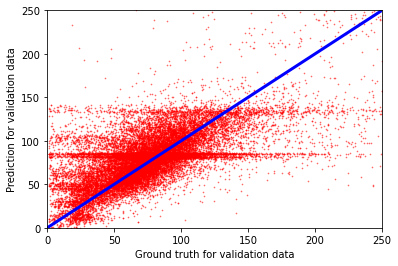

In [23]:
validateMSE(train_38_sfs, 0.33, 1)

### Test data

In [ ]:
test = pd.read_csv('drive/Shareddrives/DS4W-Team/Data/test.csv', header = 0, index_col = "id")

test = transform_test_data(test, dict_facilities, train_38_predictors_sfs, train_enc)

In [ ]:
test.shape

(9705, 38)

In [ ]:
#test.to_csv("test_38_predictors.csv", index = False)

## Ignore (for reference)

### Test EDA

In [ ]:
test = pd.read_csv("/Users/yionko/Desktop/DS4W/project/kaggle_data/widsdatathon2022/test.csv", header = 0, index_col = "id")

In [ ]:
test['State_Factor'].unique()

array(['State_1', 'State_2', 'State_4', 'State_8', 'State_11', 'State_10'],
      dtype=object)

In [ ]:
test['facility_type'].nunique()

60

### Impute missing values

#### What do missing values look like? (may ignore)

Check whether 'days_with_fog', 'direction_peak_wind_speed', 'max_wind_speed', 'direction_max_wind_speed' are the same for specific year and state factor.

In [ ]:
missing_fog_wind_features = ['days_with_fog', 'direction_peak_wind_speed', 'max_wind_speed', 'direction_max_wind_speed']
                    
train[missing_fog_wind_features].describe()

,days_with_fog,direction_peak_wind_speed,max_wind_speed,direction_max_wind_speed
count,29961.000000,33946.000000,34675.000000,34675.000000
mean,109.142051,62.779974,4.190601,66.552675
std,50.699751,130.308106,6.458789,131.147834
min,12.000000,1.000000,1.000000,1.000000
25%,88.000000,1.000000,1.000000,1.000000
50%,104.000000,1.000000,1.000000,1.000000
75%,131.000000,1.000000,1.000000,1.000000
max,311.000000,360.000000,23.300000,360.000000


In [ ]:
year_state_df = train.groupby(['Year_Factor', 'State_Factor'])[missing_fog_wind_features]
# same_dataframe.std(ddof=0) / same_dataframe.mean()
(year_state_df.quantile(0.75) - year_state_df.quantile(0.25)) / year_state_df.median()

days_with_fog  direction_peak_wind_speed  \
Year_Factor State_Factor                                             
1           State_1            0.000000                   0.000000   
            State_2                 NaN                        NaN   
            State_6            0.000000                   0.000000   
2           State_1            0.000000                   0.000000   
            State_2                 NaN                        NaN   
            State_6            0.202020                   0.000000   
3           State_1            0.221154                   0.203704   
            State_10           0.000000                   0.000000   
            State_2                 NaN                        NaN   
            State_6            0.064516                   0.000000   
            State_8            0.000000                   0.000000   
4           State_1            0.300000                   0.000000   
            State_10                NaN                        NaN   
            State_2            0.000000                   0.000000   
            State_4            0.000000                        NaN   
            State_6            0.000000                   0.000000   
            State_8            0.643678                   0.000000   
5           State_1            0.000000                   0.000000   
            State_10           0.000000                   0.000000   
            State_11                NaN                        NaN   
            State_2                 NaN                        NaN   
            State_4            0.397727                   0.000000   
            State_6            0.342342                   0.088235   
            State_8            0.000000                   0.000000   
6           State_1                 NaN                   0.000000   
            State_10           0.000000                   0.000000   
            State_11           0.000000                   0.000000   
            State_2            0.000000                   0.000000   
            State_4            0.726592                   0.000000   
            State_6            0.000000                   0.000000   
            State_8            0.000000                   0.000000   

                          max_wind_speed  direction_max_wind_speed  
Year_Factor State_Factor                                            
1           State_1             0.000000                  0.000000  
            State_2                  NaN                       NaN  
            State_6             0.000000                  0.000000  
2           State_1             0.000000                  0.000000  
            State_2                  NaN                       NaN  
            State_6             0.000000                  0.000000  
3           State_1             0.402985                  0.300000  
            State_10            0.000000                  0.000000  
            State_2                  NaN                       NaN  
            State_6             0.000000                  0.000000  
            State_8             0.000000                  0.000000  
4           State_1             0.000000                  0.000000  
            State_10                 NaN                       NaN  
            State_2             0.000000                  0.000000  
            State_4                  NaN                       NaN  
            State_6             0.000000                  0.000000  
            State_8             0.000000                  0.000000  
5           State_1             0.000000                  0.000000  
            State_10            0.000000                  0.000000  
            State_11                 NaN                       NaN  
            State_2                  NaN                       NaN  
            State_4             0.000000                  0.000000  
            State_6             0.071038                  0

#### Year 4 and State 8 (may ignore)
I looked specifically in year 4 and state 8 to see that non-missing days_with_fog values are constant within subgroups.

The weather related features are partitioned into two parts, the values are all the same for each part. Therefore, we can impute the missing values according to non-missing days_with_fog values in the group.

In [ ]:
year4_state8 = train[(train['Year_Factor'] == 4) & (train['State_Factor'] == 'State_8')]

In [ ]:
year4_state8.groupby(['avg_temp', 'precipitation_inches'])['days_with_fog'].unique()

In [ ]:
year4_state8.groupby(['avg_temp', 'precipitation_inches'])['days_with_fog'].value_counts().sum()

In [ ]:
year_state_temp_df = train.groupby(['Year_Factor', 'State_Factor', 'avg_temp'])[missing_fog_wind_features].transform(lambda x: x.unique() 
                                                                                                                     if x.nunique() == 1 
                                                                                                                     else (x.unique()*x.value_counts())/x.value_counts().sum())


In [ ]:
year4_state8.groupby(['avg_temp', 'precipitation_inches'])['direction_peak_wind_speed'].unique()

In [ ]:
year4_state8.groupby(['avg_temp', 'precipitation_inches'])['direction_peak_wind_speed'].value_counts()

In [ ]:
year4_state8.groupby(['avg_temp', 'precipitation_inches'])['direction_max_wind_speed'].unique()

In [ ]:
year4_state8.groupby(['avg_temp', 'precipitation_inches'])['max_wind_speed'].unique()

#### days_with_fog is not correlated with any other weather features. (may ignore)

Combined with the above observation, we impute days_with_fog accor

In [ ]:
columns = train.columns.to_list()
columns.index('days_above_100F')
weather_related_features = columns[columns.index('cooling_degree_days'): columns.index('days_above_100F') + 1]
weather_related_features

['cooling_degree_days',
 'heating_degree_days',
 'precipitation_inches',
 'snowfall_inches',
 'snowdepth_inches',
 'avg_temp',
 'days_below_30F',
 'days_below_20F',
 'days_below_10F',
 'days_below_0F',
 'days_above_80F',
 'days_above_90F',
 'days_above_100F']

In [ ]:
    
# for i, col in enumerate(fog_related_features):

#     plt.figure(figsize = (4,4))
#     plt.plot(train[col], train['days_with_fog'], 'ro')
#     plt.xlabel(col)
#     plt.ylabel("days with fog")
    
fig, axs = plt.subplots(5, 3, figsize=(12, 17), dpi=150)
axs = axs.ravel()
for i,j in enumerate(weather_related_features):
    axs[i].scatter(train[j],train['days_with_fog'])
    axs[i].set_ylabel('days_with_fog')
    axs[i].set_xlabel(j)

#### Impute missing wind fog features 
Impute missing wind fog features by the non-missing value (constant) in the same year, state and avg_temp subgroup. If all values are missing in the subgroup, then impute by year state weighted average.

In [ ]:
train[missing_fog_wind_features] = train.groupby(['Year_Factor', 'State_Factor', 'avg_temp'])[missing_fog_wind_features].transform('mean')
train[missing_fog_wind_features] = train.groupby(['Year_Factor', 'State_Factor'])[missing_fog_wind_features].transform(lambda x: x.fillna(x.mean()))
train[missing_fog_wind_features] = train.groupby('Year_Factor')[missing_fog_wind_features].transform(lambda x: x.fillna(x.mean()))


#### Impute energy_star_rating

In [ ]:
train['energy_star_rating'] = train.groupby('heating_degree_days')['energy_star_rating'].transform('mean')


In [ ]:
train = load_data()
train['energy_star_rating'].mean()

61.048605447724675

#### Impute year_built and transform it to 'age'

In [ ]:
train['year_built'] = np.where((train.year_built==0) | (np.isnan(train.year_built)), train.year_built.median(), train.year_built)
train['age'] = 2022 - train['year_built']
train.drop('year_built', axis = 1, inplace = True)

### Variable Transformation

Log transformation of floor_area

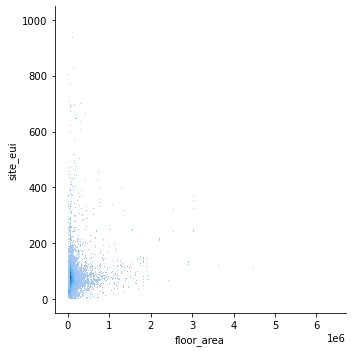

In [ ]:

floor_plot = sns.displot(train, x="floor_area", y="site_eui")
fig = floor_plot.get_figure()
fig.savefig("floor_pre.png") 


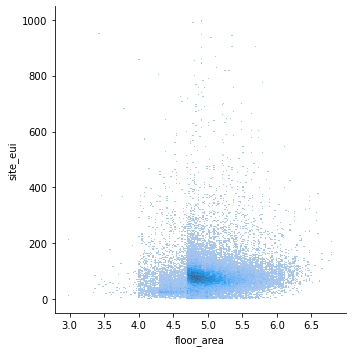

In [ ]:
train['floor_area'] = np.log10(train['floor_area'])
sns.displot(train, x="floor_area", y="site_eui")

### Add a temp_year_span variable

temp_year_span = max temperature in a year - min temperature in a year

In [ ]:
train['temp_year_span'] = max(train.iloc[:, 8:44].max()) - min(train.iloc[:, 8:44].min())

### Transform categorical variables to dummies

In [ ]:
train['Year_Factor'] = train['Year_Factor'].astype('object')
Categorical_features = train.select_dtypes(include='object').columns.to_list()
Categorical_features

['Year_Factor', 'State_Factor', 'building_class', 'facility_type']

In [ ]:
x_cat = train[Categorical_features]

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(x_cat)

x_cat_arr = enc.transform(x_cat).toarray()

x_cat_df = pd.DataFrame(x_cat_arr, columns = enc.get_feature_names(Categorical_features))

In [ ]:
train = pd.concat([train, x_cat_df], axis = 1).drop(Categorical_features, axis = 1)

In [ ]:
display(train)

,floor_area,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,age,temp_year_span,1_min,2_min,3_min,1_avg,2_avg,3_avg,1_max,2_max,3_max,Year_Factor_1,Year_Factor_2,Year_Factor_3,Year_Factor_4,Year_Factor_5,Year_Factor_6,State_Factor_State_1,State_Factor_State_10,State_Factor_State_11,State_Factor_State_2,State_Factor_State_4,State_Factor_State_6,State_Factor_State_8,building_class_Commercial,building_class_Residential,facility_type_2to4_Unit_Building,facility_type_5plus_Unit_Building,facility_type_Commercial_Other,facility_type_Commercial_Unknown,facility_type_Data_Center,facility_type_Education_College_or_university,facility_type_Education_Other_classroom,facility_type_Education_Preschool_or_daycare,facility_type_Education_Uncategorized,facility_type_Food_Sales,facility_type_Food_Service_Other,facility_type_Food_Service_Restaurant_or_cafeteria,facility_type_Food_Service_Uncategorized,facility_type_Grocery_store_or_food_market,facility_type_Health_Care_Inpatient,facility_type_Health_Care_Outpatient_Clinic,facility_type_Health_Care_Outpatient_Uncategorized,facility_type_Health_Care_Uncategorized,facility_type_Industrial,facility_type_Laboratory,facility_type_Lodging_Dormitory_or_fraternity_sorority,facility_type_Lodging_Hotel,facility_type_Lodging_Other,facility_type_Lodging_Uncategorized,facility_type_Mixed_Use_Commercial_and_Residential,facility_type_Mixed_Use_Predominantly_Commercial,facility_type_Mixed_Use_Predominantly_Residential,facility_type_Multifamily_Uncategorized,facility_type_Nursing_Home,facility_type_Office_Bank_or_other_financial,facility_type_Office_Medical_non_diagnostic,facility_type_Office_Mixed_use,facility_type_Office_Uncategorized,facility_type_Parking_Garage,facility_type_Public_Assembly_Drama_theater,facility_type_Public_Assembly_Entertainment_culture,facility_type_Public_Assembly_Library,facility_type_Public_Assembly_Movie_Theater,facility_type_Public_Assembly_Other,facility_type_Public_Assembly_Recreation,facility_type_Public_Assembly_Social_meeting,facility_type_Public_Assembly_Stadium,facility_type_Public_Assembly_Uncategorized,facility_type_Public_Safety_Courthouse,facility_type_Public_Safety_Fire_or_police_station,facility_type_Public_Safety_Penitentiary,facility_type_Public_Safety_Uncategorized,facility_type_Religious_worship,facility_type_Retail_Enclosed_mall,facility_type_Retail_Strip_shopping_mall,facility_type_Retail_Uncategorized,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized
0,4.787049,76.448980,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,248.682615,80.0,4964.0,35,46,36,52.570709,61.378387,55.363441,80,90,83,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.437751,76.448980,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,26.500150,67.0,4964.0,35,46,36,52.570709,61.378387,55.363441,80,90,83,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0

### Delete highly correlated variables

In [ ]:
corr = train.corr()
high_corr = corr[np.abs(corr) > 0.9]
high_corr_list = []
for i in range(len(high_corr)):
    for j in range(i+1):
        value = high_corr.iloc[i, j]
        if pd.notnull(value) and value != 1:
            high_corr_list.append([high_corr.columns[i], high_corr.columns[j]])
high_corr_list

[['days_below_10F', 'days_below_20F'],
 ['direction_peak_wind_speed', 'direction_max_wind_speed'],
 ['max_wind_speed', 'direction_max_wind_speed'],
 ['max_wind_speed', 'direction_peak_wind_speed'],
 ['1_avg', 'heating_degree_days'],
 ['2_avg', 'cooling_degree_days'],
 ['Year_Factor_5', 'direction_max_wind_speed'],
 ['Year_Factor_5', 'direction_peak_wind_speed'],
 ['Year_Factor_5', 'max_wind_speed'],
 ['building_class_Residential', 'building_class_Commercial']]

According to full_IV in Monica's EDA:

1. days_below_10F < days_below_20F, delete days_below_10F.


2. direction_max_wind_speed < max_wind_speed < direction_peak_wind_speed, delete direction_max_wind_speed and max_wind_speed.

In [ ]:
to_be_deleted_variables = ['days_below_10F', 'direction_max_wind_speed', 'max_wind_speed']
train.drop(to_be_deleted_variables, axis = 1, inplace = True)
train.shape

(75757, 105)

### Extract seasonal effects

#### Group 36 temperature variables (may ignore)

Since the R^2 for Sahar's way to group seasonal effect is dropped from 0.34 (full model) to 0.244. I want to find a better way to extract seasonal effects. I use K-means to cluster 36 temp variables.

The R^2 in this case is still 0.244.

In [ ]:
months = ['january', 'february', 'march', 'april', 'may', 'june', 'july',
          'august', 'september', 'october', 'november', 'december']

In [ ]:
january_min_temp_index = train.columns.tolist().index('january_min_temp')

In [ ]:
temp = train.iloc[:, january_min_temp_index:january_min_temp_index+36]

In [ ]:
temp_transpose = temp.transpose()

In [ ]:
n_clusters = 4
Kmean = KMeans(n_clusters=n_clusters)
Kmean.fit(temp_transpose)
Kmean.labels_
  

array([1, 2, 0, 1, 2, 0, 1, 2, 0, 2, 2, 3, 2, 0, 3, 2, 0, 3, 0, 0, 3, 0,
       0, 3, 2, 0, 3, 2, 0, 3, 1, 2, 0, 1, 2, 0], dtype=int32)

We can see that Dec - Mar have the same pattern in terms of clustering (label: 241/243), Apr - May, June - Sep, Oct - Nov are similar. So we group the min, avg and max of the same month together and find the clustering of months.

#### Group months (We use this one)

In [ ]:
month_temp = pd.DataFrame()
for i in range(12):
    
    one_of_three = temp.iloc[:, i * 3]
    one_month = pd.Series(one_of_three)
    for j in range(1, 3):
        one_of_three = temp.iloc[:, i * 3 + j]
        one_month = one_month.append(one_of_three, ignore_index = True)
    month_temp[months[i]] = one_month                            
month_temp_transpose = month_temp.transpose()

In [ ]:

n_clusters = 4
Kmean = KMeans(n_clusters=n_clusters)
Kmean.fit(month_temp_transpose)
Kmean.labels_

array([2, 2, 0, 3, 3, 1, 1, 1, 1, 3, 0, 0], dtype=int32)

We try to group 
1. Jan-Feb into group 1 (coldest months). 

2. March, Nov and Dec: group 2 (second coldest months).

3. Apr, May and Oct: group 3 (Spring and Fall). 

4. June-Sept: group 4 (Summer).

In [ ]:
# lets create seasons! 
train['1_min']=train[['january_min_temp','february_min_temp']].min(axis=1)
train['2_min']=train[['march_min_temp', 'november_min_temp','december_min_temp']].min(axis=1)
train['3_min']=train[['april_min_temp', 'may_min_temp', 'october_min_temp']].min(axis=1)
train['4_min']=train[['june_min_temp','july_min_temp','august_min_temp','september_min_temp']].min(axis=1)


train['1_avg']=train[['january_avg_temp','february_avg_temp']].min(axis=1)
train['2_avg']=train[['march_avg_temp', 'november_avg_temp','december_avg_temp']].min(axis=1)
train['3_avg']=train[['april_avg_temp', 'may_avg_temp', 'october_avg_temp']].min(axis=1)
train['4_avg']=train[['june_avg_temp','july_avg_temp','august_avg_temp','september_avg_temp']].min(axis=1)

train['1_max']=train[['january_max_temp','february_max_temp']].min(axis=1)
train['2_max']=train[['march_max_temp', 'november_max_temp','december_max_temp']].min(axis=1)
train['3_max']=train[['april_max_temp', 'may_max_temp', 'october_max_temp']].min(axis=1)
train['4_max']=train[['june_max_temp','july_max_temp','august_max_temp','september_max_temp']].min(axis=1)

# drop months
for i in months:
    train.drop([f'{i}_min_temp'],axis=1,inplace=True)
    train.drop([f'{i}_avg_temp'],axis=1,inplace=True)
    train.drop([f'{i}_max_temp'],axis=1,inplace=True)
display(train) 

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,1_min,2_min,3_min,4_min,1_avg,2_avg,3_avg,4_avg,1_max,2_max,3_max,4_max
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,35,36,41,50,50.500000,49.274194,55.500000,60.500000,68,71,78,84
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,35,36,41,50,50.500000,49.274194,55.500000,60.500000,68,71,78,84
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,35,36,41,50,50.500000,49.274194,55.500000,60.500000,68,71,78,84
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,35,36,41,50,50.500000,49.274194,55.500000,60.500000,68,71,78,84
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,35,36,41,50,50.500000,49.274194,55.500000,60.500000,68,71,78,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,8.0,36.6,260,3772,45.03,1.4,1,55.147541,6,0,0,0,25,3,0,0,NaN,NaN,NaN,NaN,132.918411,28,24,39,44,43.451613,38.532258,55.403226,61.383333,56,51,68,79
75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,98.0,36.6,260,3772,45.03,1.4,1,55.147541,6,0,0,0,25,3,0,0,NaN,NaN,NaN,NaN,39.483672,28,24,39,44,43.451613,38.532258,55.403226,61.383333,56,51,68,79
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,NaN,36.6,55,6218,106.32,36.6,438,47.911202,26,2,0,0,6,0,0,0,NaN,NaN,NaN,NaN,48.404398,26,15,34,41,36.612903,30.338710,47.661290,53.783333,48,46,59,73


In [ ]:
ols(train)

ValueError: ignored

R^2 = 0.245, improved only by a little.

#### (Ignore) Try to cluster min, avg, and max variables seperately. 

In [ ]:
min_temp = temp.iloc[:, ::3]

In [ ]:
min_temp_transpose = min_temp.transpose()

In [ ]:
n_clusters = 4
Kmean = KMeans(n_clusters=n_clusters)
Kmean.fit(min_temp_transpose)
Kmean.labels_

In [ ]:
min_temp = temp.iloc[1:, ::3]
min_temp_transpose = min_temp.transpose()
n_clusters = 4
Kmean = KMeans(n_clusters=n_clusters)
Kmean.fit(min_temp_transpose)
Kmean.labels_

In [ ]:
min_temp = temp.iloc[2:, ::3]
min_temp_transpose = min_temp.transpose()
n_clusters = 4
Kmean = KMeans(n_clusters=n_clusters)
Kmean.fit(min_temp_transpose)
Kmean.labels_

In [ ]:
# lets create seasons! (from Sahar's EDA)
train = clean()
train['1_min']=train[['january_min_temp','february_min_temp']].min(axis=1)
train['2_min']=train[['march_min_temp', 'april_min_temp', 'november_min_temp','december_min_temp']].min(axis=1)
train['3_min']=train[['may_min_temp', 'october_min_temp']].min(axis=1)
train['4_min']=train[['june_min_temp','july_min_temp','august_min_temp','september_min_temp']].min(axis=1)


train['1_avg']=train[['january_avg_temp','february_avg_temp']].min(axis=1)
train['2_avg']=train[['march_avg_temp', 'april_avg_temp', 'november_avg_temp','december_avg_temp']].min(axis=1)
train['3_avg']=train[['may_avg_temp', 'october_avg_temp']].min(axis=1)
train['4_avg']=train[['june_avg_temp','july_avg_temp','august_avg_temp','september_avg_temp']].min(axis=1)

train['1_max']=train[['january_max_temp','february_max_temp', 'march_max_temp']].min(axis=1)
train['2_max']=train[['april_max_temp', 'november_max_temp','december_max_temp']].min(axis=1)
train['3_max']=train[['may_max_temp', 'october_max_temp']].min(axis=1)
train['4_max']=train[['june_max_temp','july_max_temp','august_max_temp','september_max_temp']].min(axis=1)

# drop months
for i in months:
    train.drop([f'{i}_min_temp'],axis=1,inplace=True)
    train.drop([f'{i}_avg_temp'],axis=1,inplace=True)
    train.drop([f'{i}_max_temp'],axis=1,inplace=True)
display(train) 

In [ ]:
ols(train)

### Group facility types

In [ ]:
# get preprocessed data with facility dummies but without grouping facility types.
train = load_data()
clean_without_grouping_facility_types(train)

In [ ]:
facility_index = []
column_names = train.columns.tolist()
for i, s in enumerate(column_names):
    if "facility_type" in s:
        facility_index.append(i)

In [ ]:
facility_names = column_names[facility_index[0]:(facility_index[-1]+1)]
facility_names

['facility_type_2to4_Unit_Building',
 'facility_type_5plus_Unit_Building',
 'facility_type_Commercial_Other',
 'facility_type_Commercial_Unknown',
 'facility_type_Data_Center',
 'facility_type_Education_College_or_university',
 'facility_type_Education_Other_classroom',
 'facility_type_Education_Preschool_or_daycare',
 'facility_type_Education_Uncategorized',
 'facility_type_Food_Sales',
 'facility_type_Food_Service_Other',
 'facility_type_Food_Service_Restaurant_or_cafeteria',
 'facility_type_Food_Service_Uncategorized',
 'facility_type_Grocery_store_or_food_market',
 'facility_type_Health_Care_Inpatient',
 'facility_type_Health_Care_Outpatient_Clinic',
 'facility_type_Health_Care_Outpatient_Uncategorized',
 'facility_type_Health_Care_Uncategorized',
 'facility_type_Industrial',
 'facility_type_Laboratory',
 'facility_type_Lodging_Dormitory_or_fraternity_sorority',
 'facility_type_Lodging_Hotel',
 'facility_type_Lodging_Other',
 'facility_type_Lodging_Uncategorized',
 'facility_type_M

In [ ]:
facilities = train.iloc[:, facility_index[0]:(facility_index[-1]+1)]
facilities_transpose = facilities.transpose()
n_clusters = 25
Kmean = KMeans(n_clusters=n_clusters)
Kmean.fit(facilities_transpose)
facility_groups = Kmean.labels_

In [ ]:
dict_facilites = {}
for i in range(60):
    dict_facilites.update({facility_names[i][14:]: f'facility_group_{facility_groups[i]}'})

{'2to4_Unit_Building': 'facility_group_6',
 '5plus_Unit_Building': 'facility_group_8',
 'Commercial_Other': 'facility_group_10',
 'Commercial_Unknown': 'facility_group_2',
 'Data_Center': 'facility_group_2',
 'Education_College_or_university': 'facility_group_9',
 'Education_Other_classroom': 'facility_group_4',
 'Education_Preschool_or_daycare': 'facility_group_2',
 'Education_Uncategorized': 'facility_group_18',
 'Food_Sales': 'facility_group_2',
 'Food_Service_Other': 'facility_group_2',
 'Food_Service_Restaurant_or_cafeteria': 'facility_group_2',
 'Food_Service_Uncategorized': 'facility_group_2',
 'Grocery_store_or_food_market': 'facility_group_17',
 'Health_Care_Inpatient': 'facility_group_14',
 'Health_Care_Outpatient_Clinic': 'facility_group_2',
 'Health_Care_Outpatient_Uncategorized': 'facility_group_2',
 'Health_Care_Uncategorized': 'facility_group_2',
 'Industrial': 'facility_group_20',
 'Laboratory': 'facility_group_2',
 'Lodging_Dormitory_or_fraternity_sorority': 'facility_

In [ ]:
# Get prepoccessed dataset but before changing facility variables to dummies.
train_without_dummy = clean_without_dummy()
# Group facilities.
train_without_dummy['facility_type'] = train_without_dummy['facility_type'].replace(dict_facilites)


In [ ]:
train_without_dummy['facility_type']

id
0        facility_group_17
1        facility_group_19
2         facility_group_2
3         facility_group_4
4         facility_group_7
               ...        
75752     facility_group_3
75753     facility_group_8
75754    facility_group_10
75755    facility_group_10
75756     facility_group_6
Name: facility_type, Length: 75757, dtype: object

In [ ]:
# Categorical variables to dummies
train = to_dummies(train_without_dummy)
train

,floor_area,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_peak_wind_speed,days_with_fog,site_eui,age,temp_year_span,1_min,2_min,3_min,4_min,1_avg,2_avg,3_avg,4_avg,1_max,2_max,3_max,4_max,Year_Factor_1,Year_Factor_2,Year_Factor_3,Year_Factor_4,Year_Factor_5,Year_Factor_6,State_Factor_State_1,State_Factor_State_10,State_Factor_State_11,State_Factor_State_2,State_Factor_State_4,State_Factor_State_6,State_Factor_State_8,building_class_Commercial,building_class_Residential,facility_type_facility_group_0,facility_type_facility_group_1,facility_type_facility_group_10,facility_type_facility_group_11,facility_type_facility_group_12,facility_type_facility_group_13,facility_type_facility_group_14,facility_type_facility_group_15,facility_type_facility_group_16,facility_type_facility_group_17,facility_type_facility_group_18,facility_type_facility_group_19,facility_type_facility_group_2,facility_type_facility_group_20,facility_type_facility_group_21,facility_type_facility_group_22,facility_type_facility_group_23,facility_type_facility_group_24,facility_type_facility_group_3,facility_type_facility_group_4,facility_type_facility_group_5,facility_type_facility_group_6,facility_type_facility_group_7,facility_type_facility_group_8,facility_type_facility_group_9
0,4.787049,76.448980,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,14,0,0,0,1.0,12.0,248.682615,80.0,4964.0,35,36,41,50,50.500000,49.274194,55.500000,60.500000,68,71,78,84,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.437751,76.448980,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,14,0,0,0,1.0,12.0,26.500150,67.0,4964.0,35,36,41,50,50.500000,49.274194,55.500000,60.500000,68,71,78,84,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.447197,76.448980,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,14,0,0,0,1.0,12.0,24.693619,71.0,4964.0,35,36,41,50,50.500000,49.274194,55.500000,60.500000,68,71,78,84,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.742921,76.448980,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,14,0,0,0,1.0,12.0,48.406926,42.0,4964.0,35,36,41,50,50.500000,49.274194,55.500000,60.500000,68,71,78,84,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4.819544,76.448980,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,14,0,0,0,1.0,12.0,3.899395,37.0,4964.0,35,36,41,50,50.500000,49.274194,55.500000,60.500000,68,71,78,84,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,4.309843,68.047914,36.6,260,3772,45.03,1.4,1,55.147541,6,0,0,25,3,0,0,1.0,261.0,132.918411,27.0,4964.0,28,24,39,44,43.451613,38.532258,55.403226,61.383333,56,51,68,79,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
75753,4.607337,68.047914,36.6,260,3772,45.03,1.4,1,55.147541,6,0,0,25,3,0,0,1.0,261.0,39.483672,112.0,4964.0,28,24,39,44,43.451613,38.532258,55.403226,61.383333,56,51,68,79,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

### Model Selection

#### full model

In [ ]:
train = load_data()
train = final_clean(train)
display(train)

,floor_area,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_peak_wind_speed,days_with_fog,site_eui,age,temp_year_span,1_min,2_min,3_min,4_min,1_avg,2_avg,3_avg,4_avg,1_max,2_max,3_max,4_max,Year_Factor_1,Year_Factor_2,Year_Factor_3,Year_Factor_4,Year_Factor_5,Year_Factor_6,State_Factor_State_1,State_Factor_State_10,State_Factor_State_11,State_Factor_State_2,State_Factor_State_4,State_Factor_State_6,State_Factor_State_8,building_class_Commercial,building_class_Residential,facility_type_facility_group_0,facility_type_facility_group_1,facility_type_facility_group_10,facility_type_facility_group_11,facility_type_facility_group_12,facility_type_facility_group_13,facility_type_facility_group_14,facility_type_facility_group_15,facility_type_facility_group_16,facility_type_facility_group_17,facility_type_facility_group_18,facility_type_facility_group_19,facility_type_facility_group_2,facility_type_facility_group_20,facility_type_facility_group_21,facility_type_facility_group_22,facility_type_facility_group_23,facility_type_facility_group_24,facility_type_facility_group_3,facility_type_facility_group_4,facility_type_facility_group_5,facility_type_facility_group_6,facility_type_facility_group_7,facility_type_facility_group_8,facility_type_facility_group_9
0,4.787049,76.448980,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,14,0,0,0,1.0,12.0,248.682615,80.0,4964.0,35,36,41,50,50.500000,49.274194,55.500000,60.500000,68,71,78,84,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.437751,76.448980,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,14,0,0,0,1.0,12.0,26.500150,67.0,4964.0,35,36,41,50,50.500000,49.274194,55.500000,60.500000,68,71,78,84,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.447197,76.448980,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,14,0,0,0,1.0,12.0,24.693619,71.0,4964.0,35,36,41,50,50.500000,49.274194,55.500000,60.500000,68,71,78,84,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.742921,76.448980,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,14,0,0,0,1.0,12.0,48.406926,42.0,4964.0,35,36,41,50,50.500000,49.274194,55.500000,60.500000,68,71,78,84,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4.819544,76.448980,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,14,0,0,0,1.0,12.0,3.899395,37.0,4964.0,35,36,41,50,50.500000,49.274194,55.500000,60.500000,68,71,78,84,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,4.309843,68.047914,36.6,260,3772,45.03,1.4,1,55.147541,6,0,0,25,3,0,0,1.0,261.0,132.918411,27.0,4964.0,28,24,39,44,43.451613,38.532258,55.403226,61.383333,56,51,68,79,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75753,4.607337,68.047914,36.6,260,3772,45.03,1.4,1,55.147541,6,0,0,25,3,0,0,1.0,261.0,39.483672,112.0,4964.0,28,24,39,44,43.451613,38.532258,55.403226,61.383333,56,51,68,79,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
X = train.loc[:, train.columns != 'site_eui']
y = train['site_eui']

In [ ]:

validateMSE(train, 0.2, 1)

mae is:  28.857387376089193
mse is:  2863.5555400548023


In [ ]:
ols(train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               site_eui   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     336.7
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        17:00:12   Log-Likelihood:            -4.0555e+05
No. Observations:               75757   AIC:                         8.112e+05
Df Residuals:                   75689   BIC:                         8.119e+05
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
floor_area                         -3.5552      0.572     -6.218      0.000      -4.676      -2.435
energy_star_rating                 -0.5982      0.316     -1.893      0.058      -1.218       0.021
ELEVATION                          -0.0108      0.005     -2.251      0.024      -0.020      -0.001
cooling_degree_days                 0.0606      0.040      1.502      0.133      -0.018       0.140
heating_degree_days                -0.0423      0.041     -1.043      0.297      -0.122       0.037
precipitation_inches                0.2124      0.121      1.759      0.079      -0.024       0.449
snowfall_inches                     0.1877      0.142      1.324      0.185      -0.090       0.465
snowdepth_inches                   -0.0098      0.012     -0.798      0.425      -0.034       0.014
avg_temp                          -18.2750     14.519     -1.259      0.208     -46.733      10.183
days_below_30F                      0.0624      0.113      0.552      0.581      -0.159       0.284
days_below_20F                     -0.0805      0.257     -0.313      0.754      -0.584       0.423
days_below_0F                       0.2095      0.430      0.487      0.627      -0.634       1.053
days_above_80F                     -0.0599      0.076     -0.791      0.429      -0.208       0.088
days_above_90F                      0.1184      0.134      0.887      0.375      -0.143       0.380
days_above_100F                    -0.5161      0.305     -1.690      0.091      -1.115       0.082
days_above_110F                     0.9345      2.395      0.390      0.696      -3.759       5.628
direction_peak_wind_speed          -0.0070      0.013     -0.539      0.590      -0.033       0.019
days_with_fog                       0.0229      0.022      1.029      0.304      -0.021       0.066
age                                -0.0443      0.006     -7.158      0.000      -0.056      -0.032
temp_year_span                      0.2542      0.193      1.318      0.188      -0.124       0.632
1_min                               0.1108      0.228      0.486      0.627      -0.336       0.558
2_min                              -0.3596      0.465     -0.773      0.440      -1.272       0.553
3_min                              -0.0481      0.396     -0.122      0.903      -0.823       0.727
4_min                               0.2804      0.337      0.833      0.405      -0.379       0.940
1_avg                               0.4086      0.675      0.606      0.545      -0.913       1.731
2_avg                               0.5504      1.008      0.546      0.585      -1.426       2.527
3_avg                               0.4539      0.845      0.537      0.591      -1.202       2.110
4_avg                              -0.5458      1.030     -0.530      0.596      -2

#### p-value 0.05
Stepwise selection with p-value = 0.05 selects 38 features.

['1_avg',
 'facility_type_facility_group_18',
 'facility_type_facility_group_16',
 'facility_type_facility_group_0',
 'temp_year_span',
 'State_Factor_State_6',
 'facility_type_facility_group_3',
 'facility_type_facility_group_4',
 'facility_type_facility_group_15',
 'facility_type_facility_group_8',
 'facility_type_facility_group_13',
 'facility_type_facility_group_7',
 'facility_type_facility_group_10',
 'facility_type_facility_group_20',
 'facility_type_facility_group_19',
 'facility_type_facility_group_21',
 'facility_type_facility_group_9',
 'facility_type_facility_group_6',
 'heating_degree_days',
 'facility_type_facility_group_5',
 'facility_type_facility_group_23',
 'facility_type_facility_group_22',
 'precipitation_inches',
 'facility_type_facility_group_14',
 'age',
 'building_class_Commercial',
 'building_class_Residential',
 'floor_area',
 'facility_type_facility_group_12',
 'facility_type_facility_group_24',
 'facility_type_facility_group_1',
 '3_min',
 'facility_type_faci

In [ ]:
type(stepwise_p_features)

list

In [ ]:
stepwise_sfs_features_38 = stepwise_sfs(38)
stepwise_sfs_features_38

('floor_area',
 'energy_star_rating',
 'ELEVATION',
 'cooling_degree_days',
 'heating_degree_days',
 'precipitation_inches',
 'snowfall_inches',
 'snowdepth_inches',
 'avg_temp',
 'days_below_20F',
 'days_below_0F',
 'days_above_80F',
 'days_above_90F',
 'days_above_100F',
 'days_with_fog',
 'age',
 '1_min',
 '2_min',
 '3_min',
 '4_min',
 '1_avg',
 '2_avg',
 '4_avg',
 '3_max',
 '4_max',
 'Year_Factor_1',
 'Year_Factor_2',
 'Year_Factor_3',
 'Year_Factor_4',
 'State_Factor_State_1',
 'State_Factor_State_11',
 'State_Factor_State_2',
 'State_Factor_State_6',
 'building_class_Commercial',
 'facility_type_facility_group_0',
 'facility_type_facility_group_1',
 'facility_type_facility_group_10',
 'facility_type_facility_group_11',
 'facility_type_facility_group_12',
 'facility_type_facility_group_13',
 'facility_type_facility_group_14',
 'facility_type_facility_group_15',
 'facility_type_facility_group_16',
 'facility_type_facility_group_17',
 'facility_type_facility_group_18',
 'facility_ty

#### (ignore for now) p-value 0.01, n_features = 

In [ ]:
backward_p_feature = backward_elimination(x, y, significance_level = 0.01)

In [ ]:
len(backward_p_feature)

56

In [ ]:
forward_p_feature = forward_selection(X, y, significance_level = 0.01)

In [ ]:
len(forward_p_feature)

55

In [ ]:
len(stepwise_p_features)

In [ ]:
stepwise_sfs_features_58 = stepwise_sfs(58)

### scikit learn regression for future prediction.

In [ ]:
reg = linear_model.LinearRegression()
reg.fit(x, y)